# Attempt 1

In [2]:
import os
import re
import pandas as pd
import numpy as np
from transformers import pipeline
from datetime import datetime

In [3]:
# Load Toxicity Model
model_name = "unitary/unbiased-toxic-roberta"
toxicity_pipeline = pipeline("text-classification", model=model_name)

# Define debate directory (only Presidential Debates)
DEBATE_DIR = "data_script/presidential"

Device set to use mps:0


In [19]:
# Function to extract year from filename
def extract_year(filename):
    match = re.search(r'(\d{4})', filename)
    return int(match.group(1)) if match else None

def identify_speaker_party(speaker):
    """Maps a speaker to 'republican', 'democrat', or 'moderator' based on full names and titles."""
    speaker = speaker.lower().strip()

    # Handle special moderator cases
    if "moderator" in speaker:
        return "moderator"

    # Extract last name if a title exists
    words = speaker.split()
    last_name = words[-1] if len(words) > 1 else speaker

    # Known Republicans
    republican_keywords = {"trump", "romney", "mccain", "bush", "reagan", "ford", "nixon", "dole",
                           "goldwater", "rockefeller", "hoover"}

    # Known Democrats
    democrat_keywords = {"biden", "obama", "kerry", "clinton", "dukakis", "carter", "johnson",
                         "humphrey", "mcgovern", "mondale", "gore"}

    # Known Moderators
    moderator_keywords = {"wallace", "welker", "lehrer", "guthrie", "holt", "king", "margaret",
                          "stephanopoulos", "raddatz", "baier", "cooper", "woodruff", "quayle",
                          "ifill", "schieffer", "sander", "shaw", "smith", "panelist", "questioner"}

    # Check last name for party affiliation
    if last_name in republican_keywords:
        return "republican"
    elif last_name in democrat_keywords:
        return "democrat"
    elif last_name in moderator_keywords:
        return "moderator"
    else:
        return "unknown"
    
# Function to split text into sentences
def split_into_sentences(text):
    return re.split(r'(?<=[.!?])\s+', text)

def extract_speakers_and_statements(debate_text):
    """
    Extracts speakers and their statements from different debate styles.
    Handles variations in formatting including colons, periods, and dashes.
    """
    sentences = []
    
    # Handle [laughter], [applause], (inaudible) – clean the text
    cleaned_text = re.sub(r"\[.*?\]|\(.*?\)", "", debate_text)

    # Define multiple regex patterns to match different debate styles
    patterns = [
        (r"^([A-Z\s]+):\s*(.+)$", "colon_style"),  # STYLE 1 & 4: Uppercase names with a colon
        (r"^(President\s+\w+|Mr\.|Ms\.)\s*(\w+)\.\s*(.+)$", "title_period_style"),  # STYLE 2 & 3: Speaker name before a period
        (r"^(THE MODERATOR)\.\s*(.+)$", "moderator_period_style"),  # STYLE 5: "THE MODERATOR." followed by text
        (r"^([A-Z\s]+,\s+MODERATOR):\s*(.+)$", "moderator_colon_style"),  # STYLE 4: "FRANK McGEE, MODERATOR:"
    ]
    
    for line in cleaned_text.split("\n"):
        line = line.strip()
        if not line:
            continue  # Skip empty lines

        matched = False
        for pattern, style in patterns:
            match = re.match(pattern, line)
            if match:
                matched = True
                if style == "colon_style":
                    speaker, statement = match.groups()
                elif style == "title_period_style":
                    title, speaker, statement = match.groups()
                    speaker = f"{title} {speaker}"  # Reconstruct speaker (e.g., "President Bush")
                elif style == "moderator_period_style":
                    speaker, statement = match.groups()
                elif style == "moderator_colon_style":
                    speaker, statement = match.groups()
                    speaker = speaker.replace(", MODERATOR", "").strip()  # Remove "MODERATOR" tag
                
                # Tokenize into sentences
                for sentence in split_into_sentences(statement):
                    sentences.append({
                        "speaker": speaker.strip().lower(),
                        "statement": sentence.lower().strip()
                    })
                break  # Stop checking other patterns if one matches
        
        # Handle cases where no regex pattern matches (possible informal styles)
        if not matched and "." in line:
            parts = line.split(".", 1)  # Assume the first sentence contains the speaker
            if len(parts) == 2:
                potential_speaker, statement = parts
                if len(potential_speaker.split()) < 4:  # Avoid capturing long intros
                    for sentence in split_into_sentences(statement):
                        sentences.append({
                            "speaker": potential_speaker.strip().lower(),
                            "statement": sentence.lower().strip()
                        })

    return sentences

In [ ]:
# Process all presidential debate transcripts
data_list = []

for filename in os.listdir(DEBATE_DIR):
    if filename.endswith("_pd.txt"):  # Ensure only presidential debates are processed
        year = extract_year(filename)
        with open(os.path.join(DEBATE_DIR, filename), "r", encoding="utf-8") as f:
            debate_text = f.read()

        # Extract speakers and statements using the improved function
        sentences = extract_speakers_and_statements(debate_text)

        # Convert to DataFrame
        df = pd.DataFrame(sentences)

        # Add year and party
        df["year"] = year
        df["party"] = df["speaker"].apply(identify_speaker_party)

        # Remove empty statements (only once)
        df = df[df["statement"].str.strip() != ""]

        # Compute hostility scores
        batch_size = 8
        statements_list = df["statement"].tolist()
        hostility_scores = toxicity_pipeline(statements_list, batch_size=batch_size, truncation=True, max_length=512)

        # Assign hostility scores to DataFrame
        df["hostility_score"] = [result["score"] for result in hostility_scores]

        # Append to main list
        data_list.append(df)

In [21]:
# Combine all data into one DataFrame
full_df = pd.concat(data_list, ignore_index=True)

# Aggregate hostility scores by party and year
final_results = full_df.groupby(["year", "party"])["hostility_score"].mean().reset_index()

# Save to CSV
final_results.to_csv("debate_hostility_scores.csv", index=False)

In [22]:
final_results = final_results.sort_values(by="year", ascending=False)

# Display sorted results with styling
final_results.style.set_properties(**{"text-align": "center"}).set_caption("Presidential Debate Hostility Scores")

,year,party,hostility_score
46,2024,unknown,0.038803
45,2024,republican,0.055288
44,2024,moderator,0.005153
43,2024,democrat,0.108988
42,2020,unknown,0.001857
41,2020,republican,0.037247
40,2020,moderator,0.031384
39,2020,democrat,0.038619
37,2016,republican,0.053329
35,2016,democrat,0.053697


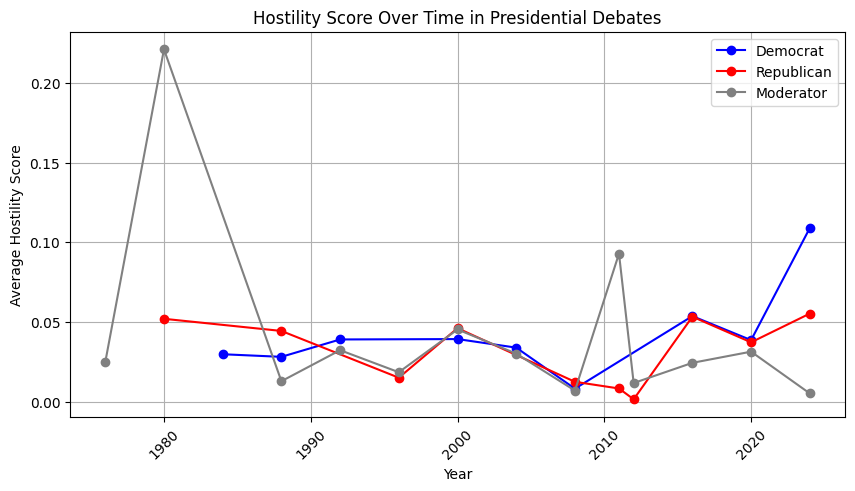

In [23]:
import matplotlib.pyplot as plt

# Sort by year in ascending order for proper plotting
final_results = final_results.sort_values(by="year", ascending=True)

# Filter for Democrats, Republicans, and Moderators
democrats = final_results[final_results["party"] == "democrat"]
republicans = final_results[final_results["party"] == "republican"]
moderators = final_results[final_results["party"] == "moderator"]

# Plot each group
plt.figure(figsize=(10, 5))
plt.plot(democrats["year"], democrats["hostility_score"], marker="o", linestyle="-", color="blue", label="Democrat")
plt.plot(republicans["year"], republicans["hostility_score"], marker="o", linestyle="-", color="red", label="Republican")
plt.plot(moderators["year"], moderators["hostility_score"], marker="o", linestyle="-", color="gray", label="Moderator")

# Formatting
plt.xlabel("Year")
plt.ylabel("Average Hostility Score")
plt.title("Hostility Score Over Time in Presidential Debates")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate year labels if necessary

# Show plot
plt.show()

**Problems:**

1. The speakers are not being identified well... at all.

# Attempt 2
In this attempt, we are explicitly writing who the speakers are.

## Part 1: Identifying speakers and splitting by sentence

In [34]:
import re
import pandas as pd
import os

In [ ]:
# Simple sentence tokenizer function to replace NLTK's sent_tokenize
def simple_sentence_tokenize(text):
    """
    Split text into sentences using simple regex patterns.
    This function replaces NLTK's sent_tokenize without external dependencies.
    """
    if not text:
        return []
        
    # Handle common abbreviations to avoid incorrect splitting
    text = re.sub(r'(Mr\.|Mrs\.|Ms\.|Dr\.|Gov\.|Sen\.)\s', r'\1PLACEHOLDER', text)
    
    # Split on sentence endings
    sentences = re.split(r'(?<=[.!?])\s+', text)
    
    # Restore spaces after abbreviations
    sentences = [re.sub(r'PLACEHOLDER', ' ', s) for s in sentences]
    
    # Filter out empty strings
    return [s.strip() for s in sentences if s.strip()]

# Create a dictionary of debate speakers based on your provided information
def build_debate_speakers_dict():
    """
    Build a dictionary mapping debate IDs to their speakers and formats.
    Returns a dictionary with debate IDs as keys and dictionaries of speaker roles and formats as values.
    """
    # Raw speaker data from your table (formatted as CSV-like text)
    speakers_data = """
    Debate,Speaker 1 (R),Speaker 2 (D),Speaker 3 (I),Moderator 1,Moderator 2,Reporter 1,Reporter 2,Reporter 3,Reporter 4,Reporter 5
    1960_09_26_pb,MR. NIXON:,MR. KENNEDY:,,Mr. SMITH:,,MR. VANOCUR:,MR. WARREN:,MR. NOVINS:,MR. FLEMING:,
    1960_10_07_pb,MR. NIXON:,MR. KENNEDY:,,MR. McGEE:,,MR. NIVEN:,MR. MORGAN:,MR. SPIVAK:,MR. LEVY:,
    1960_10_13_pb,MR. NIXON:,MR. KENNEDY:,,MR. SHADEL:,,MR. VON FREMD:,MR. CATER:,MR. DRUMMOND:,,
    1960_10_21_pb,MR. NIXON:,MR. KENNEDY:,,MR. HOWE:,,MR. SINGISER:,MR. EDWARDS:,MR. CRONKITE:,MR. CHANCELLOR:,
    1976_09_23_pb,THE PRESIDENT.,MR. CARTER.,,THE MODERATOR.,,MR. REYNOLDS.,MR. GANNON.,MS. DREW.,,
    1976_10_06_pb,THE PRESIDENT.,MR. CARTER.,,THE MODERATOR.,,MR. FRANKEL.,MR. TREWHITT.,MR. VALERIANI.,,
    1976_10_22_pb,THE PRESIDENT.,MR. CARTER.,,THE MODERATOR.,,MR. KRAFT.,MR. MAYNARD.,MR. NELSON.,,
    1980_09_21_pb,GOV. RONALD REAGAN:,,ANDERSON:,MOYERS:,,LOOMIS:,GREENBERG:,CORDDRY:,MAY:,"QUINN:,GOLDEN:"
    1980_10_28_pb,GOVERNOR REAGAN.,THE PRESIDENT.,,MR. SMITH.,,MR. STONE.,MR. ELLIS.,MR. HILLIARD.,MS. WALTERS.,
    1984_10_07_pb,The President.,Mr. Mondale.,,Ms. Walters.,,Mr. Wieghart.,Ms. Sawyer.,Mr. Barnes.,,
    1984_10_21_pb,The President.,Mr. Mondale.,,Mr. Newman,,Ms. Geyer.,Mr. Kalb.,Mr. Kondracke.,Mr. Trewhitt,
    1988_09_25_pb,BUSH:,DUKAKIS:,,LEHRER:,,MASHEK:,GROER:,JENNINGS:,,
    1988_10_13_pb,BUSH:,DUKAKIS:,,SHAW:,,COMPTON:,WARNER:,MITCHELL:,,
    1992_10_11_pb,President Bush.,Governor Clinton.,Mr. Perot.,Mr. Mashek.,,Ms. Compton.,Mr. Vanocur.,,,
    1992_10_15_pb,President Bush.,Governor Clinton.,Mr. Perot.,Ms. Simpson.,,,,,
    1992_10_19_pb,President Bush.,Governor Clinton.,Mr. Perot.,Mr. Lehrer.,,,,,
    1996_10_06_pb,Senator Dole.,The President.,,Mr. Lehrer.,,,,,
    1996_10_16_pb,Senator Dole.,The President.,,Mr. Lehrer.,,,,,
    2000_10_03_pb,BUSH:,GORE:,,MODERATOR:,,,,,
    2004_09_30_pb,President Bush.,Senator Kerry.,,Mr. Lehrer.,,,,,
    2004_10_08_pb,President Bush.,Senator Kerry.,,Mr. Gibson.,,,,,
    2004_10_13_pb,President Bush.,Senator Kerry.,,Mr. Schieffer.,,,,,
    2008_09_26_pb,MCCAIN:,OBAMA:,,LEHRER:,,,,,
    2008_10_07_pb,MCCAIN:,OBAMA:,,BROKAW:,,,,,
    2008_10_15_pb,MCCAIN:,OBAMA:,,SCHIEFFER:,,,,,
    2012_10_03_pd,Gov. Romney.,The President.,,Mr. Lehrer.,,,,,
    2012_10_16_pd,Gov. Romney.,The President.,,Ms. Crowley.,,,,,
    2012_10_22_pd,Gov. Romney.,The President.,,Mr. Schieffer.,,,,,
    2016_09_26_pd,TRUMP:,CLINTON:,,HOLT:,,,,,
    2016_10_09_pd,TRUMP:,CLINTON:,,RADDATZ:,COOPER:,,,,
    2016_10_19_pd,TRUMP:,CLINTON:,,WALLACE:,,,,,
    2020_09_29_pd,TRUMP:,BIDEN:,,WALLACE:,,,,,
    2020_10_22_pd,TRUMP:,BIDEN:,,WELKER:,,,,,
    2024_06_27_pd,TRUMP:,BIDEN:,,TAPPER:,BASH:,,,,
    2024_09_10_pd,TRUMP:,HARRIS:,,MUIR:,DAVIS:,,,,
    """
    
    # Parse the CSV-like text
    import io
    df = pd.read_csv(io.StringIO(speakers_data), sep=',')
    
    # Clean up column names
    df.columns = [col.strip() for col in df.columns]
    
    # Create a dictionary to store the debate speakers
    debate_speakers = {}
    
    for _, row in df.iterrows():
        debate_id = row['Debate'].strip()
        
        # Skip empty rows
        if not debate_id:
            continue
            
        # Initialize speakers for this debate
        speakers = {
            'republican': row['Speaker 1 (R)'].strip() if pd.notna(row['Speaker 1 (R)']) else '',
            'democrat': row['Speaker 2 (D)'].strip() if pd.notna(row['Speaker 2 (D)']) else '',
            'independent': row['Speaker 3 (I)'].strip() if pd.notna(row['Speaker 3 (I)']) else '',
            'moderators': []
        }
        
        # Add moderators
        for i in range(1, 3):
            col = f'Moderator {i}'
            if col in row and pd.notna(row[col]) and row[col].strip():
                speakers['moderators'].append(row[col].strip())
        
        # Add reporters as moderators too
        for i in range(1, 6):
            col = f'Reporter {i}'
            if col in row and pd.notna(row[col]) and row[col].strip():
                speakers['moderators'].append(row[col].strip())
        
        # Store in dictionary
        debate_speakers[debate_id] = speakers
    
    return debate_speakers

# Function to extract year from debate ID
def extract_year_from_debate_id(debate_id):
    """Extract the year from a debate ID (e.g., '1960_09_26_pb' -> 1960)."""
    match = re.match(r'(\d{4})_', debate_id)
    return int(match.group(1)) if match else None

# Function to identify speaker party
def identify_speaker_party(speaker_text, debate_id, debate_speakers):
    """
    Identify the party affiliation of a speaker.
    
    Args:
        speaker_text (str): The speaker text from the transcript.
        debate_id (str): The ID of the debate.
        debate_speakers (dict): Dictionary of debate speakers.
        
    Returns:
        str: 'republican', 'democrat', 'independent', 'moderator', or 'unknown'
    """
    if not speaker_text or not debate_id:
        return 'unknown'
    
    # Clean the speaker text
    speaker_text = speaker_text.strip().lower()
    
    # Handle special case for "THE PRESIDENT" - need to determine which party the president was from
    if "president" in speaker_text and "vice" not in speaker_text:
        year = extract_year_from_debate_id(debate_id)
        if not year:
            return 'unknown'
            
        # Map years to the party of the president at that time
        republican_president_years = [
            1960,  # Nixon was VP under Eisenhower (R)
            1976,  # Ford (R)
            1984,  # Reagan (R)
            1992,  # Bush Sr. (R)
            2004,  # Bush Jr. (R)
        ]
        
        democrat_president_years = [
            1980,  # Carter (D)
            1996,  # Clinton (D)
            2012,  # Obama (D)
            2024,  # Biden (D)
        ]
        
        if year in republican_president_years:
            return 'republican'
        elif year in democrat_president_years:
            return 'democrat'
    
    # Get the speakers for this debate
    debate_info = debate_speakers.get(debate_id, {})
    
    # Check if the speaker is in any of the known categories
    if debate_info:
        # Convert all to lowercase for case-insensitive comparison
        rep_format = debate_info.get('republican', '').lower()
        dem_format = debate_info.get('democrat', '').lower()
        ind_format = debate_info.get('independent', '').lower()
        mod_formats = [m.lower() for m in debate_info.get('moderators', [])]
        
        # Clean up speaker text and formats for better matching
        # Remove titles, colons, periods, and extra whitespace
        def clean_speaker_format(text):
            # Convert to lowercase
            text = text.lower()
            # Remove titles
            text = re.sub(r'\b(mr\.|ms\.|mrs\.|miss|senator|president|governor|gov\.|vice|the)\b', '', text)
            # Remove punctuation
            text = re.sub(r'[:.()]', '', text)
            # Normalize whitespace
            text = re.sub(r'\s+', ' ', text)
            return text.strip()
        
        speaker_clean = clean_speaker_format(speaker_text)
        rep_clean = clean_speaker_format(rep_format)
        dem_clean = clean_speaker_format(dem_format)
        ind_clean = clean_speaker_format(ind_format)
        mod_clean = [clean_speaker_format(m) for m in mod_formats]
        
        # First check for exact matches
        if rep_clean and speaker_clean == rep_clean:
            return 'republican'
        elif dem_clean and speaker_clean == dem_clean:
            return 'democrat'
        elif ind_clean and speaker_clean == ind_clean:
            return 'independent'
        elif any(speaker_clean == m for m in mod_clean):
            return 'moderator'
        
        # Check for last name matches (for moderators/reporters)
        speaker_words = speaker_clean.split()
        if speaker_words:
            speaker_last_name = speaker_words[-1]
            for mod in mod_clean:
                mod_words = mod.split()
                if mod_words and mod_words[-1] == speaker_last_name:
                    return 'moderator'
        
        # Check if speaker contains a moderator's name or vice versa
        for mod in mod_clean:
            # Check if mod name is in speaker or speaker is in mod name
            if (mod and speaker_clean and 
                (mod in speaker_clean or speaker_clean in mod)):
                return 'moderator'
            
        # Check partial matches (e.g., "TRUMP" in "TRUMP:")
        if rep_clean and (speaker_clean in rep_clean or rep_clean in speaker_clean):
            return 'republican'
        elif dem_clean and (speaker_clean in dem_clean or dem_clean in speaker_clean):
            return 'democrat'
        elif ind_clean and (speaker_clean in ind_clean or ind_clean in speaker_clean):
            return 'independent'
            
        # Special case for reporters/moderators with titles
        if speaker_text.lower().startswith(('mr.', 'ms.', 'mrs.')) and not any(word in speaker_text.lower() for word in ['trump', 'bush', 'gore', 'obama', 'biden', 'harris', 'romney', 'kerry', 'clinton']):
            return 'moderator'
    
    # If we couldn't determine from the debate formats, use knowledge-based backup
    return identify_speaker_party_fallback(speaker_text, extract_year_from_debate_id(debate_id))

# Fallback function for identifying speaker party
def identify_speaker_party_fallback(speaker, year):
    """
    Fallback function to identify speaker party based on name and year.
    Only focuses on republicans and democrats as requested.
    """
    speaker = speaker.lower().strip()
    
    # Remove titles for better matching
    speaker = re.sub(r'(mr\.|mrs\.|ms\.|senator|president|governor|gov\.|vice|the)', '', speaker).strip()
    
    # Remove any trailing punctuation
    speaker = re.sub(r'[:.]', '', speaker).strip()
    
    # Map common speaker last names to their parties by election year
    republican_candidates = {
        'nixon': [1960, 1968, 1972],
        'ford': [1976],
        'reagan': [1980, 1984],
        'bush': [1980, 1984, 1988, 1992, 2000, 2004],  # Both H.W. and W.
        'dole': [1996],
        'cheney': [2000, 2004],
        'mccain': [2008],
        'palin': [2008],
        'romney': [2012],
        'ryan': [2012],
        'trump': [2016, 2020, 2024],
        'pence': [2016, 2020]
    }
    
    democrat_candidates = {
        'kennedy': [1960],
        'johnson': [1964],
        'humphrey': [1968],
        'mcgovern': [1972],
        'carter': [1976, 1980],
        'mondale': [1984, 1976, 1980],  # VP under Carter
        'ferraro': [1984],
        'dukakis': [1988],
        'bentsen': [1988],
        'clinton': [1992, 1996, 2016],  # Both Bill and Hillary
        'gore': [1992, 1996, 2000],
        'kerry': [2004],
        'edwards': [2004],
        'obama': [2008, 2012],
        'biden': [2008, 2012, 2020, 2024],  # VP under Obama, then President
        'harris': [2020, 2024],  # VP under Biden, then candidate
        'kaine': [2016],
        'walz': [2024]
    }
    
    # Check if any republican candidate name matches
    for name, years in republican_candidates.items():
        if name in speaker and (not year or year in years):
            return 'republican'
    
    # Check if any democrat candidate name matches
    for name, years in democrat_candidates.items():
        if name in speaker and (not year or year in years):
            return 'democrat'
    
    # Check for moderator indicators
    moderator_keywords = ['moderator', 'journalist', 'reporter', 'host', 'panel']
    if any(keyword in speaker for keyword in moderator_keywords):
        return 'moderator'
    
    # If we still can't determine, consider these common moderator last names
    # Expanded list of known moderators/reporters/journalists
    moderator_names = {
        # Common moderators
        'lehrer', 'shaw', 'brokaw', 'rather', 'jennings', 'gibson', 'wallace', 
        'schieffer', 'crowley', 'cooper', 'holt', 'raddatz', 'tapper', 'bash',
        'welker', 'muir', 'davis', 'smith', 'stephanopoulos', 'russert', 'ifill',
        'simpson', 'newman', 'walters', 'king', 'blitzer',
        
        # Moderators from your data
        'mcgee', 'niven', 'morgan', 'spivak', 'levy', 'shadel', 'von fremd', 
        'cater', 'drummond', 'howe', 'singiser', 'edwards', 'cronkite', 'chancellor',
        'reynolds', 'gannon', 'drew', 'frankel', 'trewhitt', 'valeriani', 'kraft',
        'maynard', 'nelson', 'moyers', 'loomis', 'greenberg', 'corddry', 'may',
        'quinn', 'golden', 'stone', 'ellis', 'hilliard', 'wieghart', 'sawyer',
        'barnes', 'geyer', 'kalb', 'kondracke', 'mashek', 'groer', 'compton',
        'warner', 'mitchell', 'vanocur', 'simpson'
    }
    
    for name in moderator_names:
        if name in speaker:
            return 'moderator'
    
    # Special case for titles that are typically used for moderators/reporters
    if speaker.startswith(('mr', 'ms', 'mrs')) and len(speaker.split()) <= 3:
        if not any(candidate in speaker for candidate in list(republican_candidates.keys()) + list(democrat_candidates.keys())):
            return 'moderator'
    
    # By default, most speakers with titles in debates are moderators or reporters if not main candidates
    if year and year < 2000 and re.match(r'(mr|ms|mrs)\s+\w+', speaker):
        return 'moderator'
    
    return 'unknown'

# Improved function to extract speakers and statements
def extract_speakers_and_statements(debate_text, debate_id, debate_speakers):
    """
    Enhanced function to extract speakers and their statements from debate transcripts.
    Uses debate-specific speaker formats for better accuracy.
    Uses simple regex-based sentence tokenization instead of NLTK.
    
    Args:
        debate_text (str): The full text of the debate transcript.
        debate_id (str): The ID of the debate.
        debate_speakers (dict): Dictionary of debate speakers.
        
    Returns:
        list: List of dictionaries with speaker and statement information.
    """
    sentences = []
    
    # Clean the text
    cleaned_text = re.sub(r"\[.*?\]|\(.*?\)", "", debate_text)
    
    # Get the speaker formats for this debate
    debate_info = debate_speakers.get(debate_id, {})
    all_speaker_formats = []
    
    if debate_info:
        for role in ['republican', 'democrat', 'independent']:
            if debate_info.get(role):
                all_speaker_formats.append(debate_info[role])
        
        all_speaker_formats.extend(debate_info.get('moderators', []))
    
    # Escape special regex characters in speaker formats
    escaped_formats = [re.escape(fmt) for fmt in all_speaker_formats if fmt]
    
    # Create regex patterns based on debate-specific formats
    specific_patterns = []
    for fmt in escaped_formats:
        # For formats ending with colon
        if fmt.endswith('\\:'):
            specific_patterns.append(f"^({fmt[:-2]}):\\s*(.+)$")
        # For formats ending with period
        elif fmt.endswith('\\.'):
            specific_patterns.append(f"^({fmt[:-2]})\\.\\s*(.+)$")
    
    # Add generic patterns as fallbacks
    generic_patterns = [
        # Standard "NAME:" format
        r"^([A-Z][A-Z\s\.\-,']+):\s*(.+)$",
        
        # "Title Name." format
        r"^(President|Vice President|Senator|Governor|Gov\.|Mr\.|Mrs\.|Ms\.|THE PRESIDENT)\s+([A-Za-z\-']+)\.\s*(.+)$",
        r"^(THE PRESIDENT|THE MODERATOR|MODERATOR)\.\s*(.+)$",
        
        # Moderator with parenthetical
        r"^([A-Z][A-Z\s\-']+)\s*\([A-Za-z\s]+\):\s*(.+)$",
        
        # Moderator specified
        r"^([A-Z][A-Za-z\s\.\-']+),\s*MODERATOR:\s*(.+)$"
    ]
    
    # Combine specific and generic patterns
    all_patterns = specific_patterns + generic_patterns
    
    # Process the debate line by line
    current_speaker = None
    current_text = ""
    
    for line in cleaned_text.split("\n"):
        line = line.strip()
        if not line:
            # Process any accumulated text when we hit empty lines
            if current_speaker and current_text:
                for sentence in simple_sentence_tokenize(current_text):
                    if sentence.strip():
                        sentences.append({
                            "speaker": current_speaker.strip(),
                            "statement": sentence.strip()
                        })
                current_text = ""
            continue
        
        # Check if this line starts with a new speaker
        new_speaker_found = False
        
        for pattern in all_patterns:
            match = re.match(pattern, line)
            if match:
                # Process any accumulated text from previous speaker
                if current_speaker and current_text:
                    for sentence in simple_sentence_tokenize(current_text):
                        if sentence.strip():
                            sentences.append({
                                "speaker": current_speaker.strip(),
                                "statement": sentence.strip()
                            })
                
                # Extract new speaker and start accumulating their text
                groups = match.groups()
                if len(groups) == 2:
                    current_speaker, statement = groups
                elif len(groups) == 3:
                    title, name, statement = groups
                    current_speaker = f"{title} {name}"
                
                current_text = statement
                new_speaker_found = True
                break
        
        # If no new speaker pattern found, continue accumulating text for current speaker
        if not new_speaker_found and current_speaker:
            current_text += " " + line
    
    # Process any final accumulated text
    if current_speaker and current_text:
        for sentence in simple_sentence_tokenize(current_text):
            if sentence.strip():
                sentences.append({
                    "speaker": current_speaker.strip(),
                    "statement": sentence.strip()
                })
    
    # Add party information to each sentence
    for sentence in sentences:
        party = identify_speaker_party(sentence["speaker"], debate_id, debate_speakers)
        sentence["party"] = party
    
    return sentences

# Example usage function
def process_debate(filename, debate_speakers):
    """
    Process a single debate file.
    
    Args:
        filename (str): The filename of the debate transcript.
        debate_speakers (dict): Dictionary of debate speakers.
        
    Returns:
        pd.DataFrame: DataFrame with speakers, statements, and party information.
    """
    # Extract debate ID from filename
    debate_id = os.path.splitext(os.path.basename(filename))[0]
    
    # Read debate text
    with open(filename, 'r', encoding='utf-8') as f:
        debate_text = f.read()
    
    # Extract speakers and statements
    sentences = extract_speakers_and_statements(debate_text, debate_id, debate_speakers)
    
    # Convert to DataFrame
    df = pd.DataFrame(sentences)
    
    # Add metadata
    df['debate_id'] = debate_id
    
    # Extract year
    year = extract_year_from_debate_id(debate_id)
    df['year'] = year
    
    return df

In [38]:
# Build the speakers dictionary
debate_speakers = build_debate_speakers_dict()

# Process all debate files in a directory
debate_dir = "data_script/presidential"
all_debates = []

for filename in os.listdir(debate_dir):
    if filename.endswith("_pd.txt"):
        file_path = os.path.join(debate_dir, filename)
        print(f"Processing {filename}...")
        
        df = process_debate(file_path, debate_speakers)
        all_debates.append(df)
        
        print(f"  Found {len(df)} statements from {df['speaker'].nunique()} speakers")
        print(f"  Party breakdown: {df['party'].value_counts().to_dict()}")

# Combine all data
if all_debates:
    full_df = pd.concat(all_debates, ignore_index=True)
    print(f"Total dataset: {len(full_df)} statements from {full_df['year'].nunique()} election years")
    
    # Save the data
    full_df.to_csv("debate_statements_with_party.csv", index=False)

Processing 1960_09_26_pd.txt...
  Found 538 statements from 10 speakers
  Party breakdown: {'democrat': 218, 'republican': 201, 'moderator': 78, 'unknown': 41}
Processing 2012_10_16_pd.txt...
  Found 1183 statements from 3 speakers
  Party breakdown: {'republican': 527, 'democrat': 472, 'moderator': 184}
Processing 1976_09_23_pd.txt...
  Found 721 statements from 3 speakers
  Party breakdown: {'moderator': 485, 'republican': 236}
Processing 2004_10_13_pd.txt...
  Found 1009 statements from 3 speakers
  Party breakdown: {'democrat': 463, 'republican': 401, 'moderator': 145}
Processing 2008_10_07_pd.txt...
  Found 962 statements from 4 speakers
  Party breakdown: {'republican': 413, 'democrat': 369, 'moderator': 165, 'unknown': 15}
Processing 2020_09_29_pd.txt...
  Found 2394 statements from 5 speakers
  Party breakdown: {'republican': 1002, 'democrat': 820, 'moderator': 571, 'unknown': 1}
Processing 2008_10_15_pd.txt...
  Found 966 statements from 3 speakers
  Party breakdown: {'republi

# Part 2: Applying the analysis

Loading statements from debate_statements_with_party.csv
Loaded 34830 statements

Sample data:
                      speaker  \
0  HOWARD K. SMITH, MODERATOR   
1  HOWARD K. SMITH, MODERATOR   
2  HOWARD K. SMITH, MODERATOR   
3  HOWARD K. SMITH, MODERATOR   
4  HOWARD K. SMITH, MODERATOR   

                                           statement      party  \
0                                      Good evening.  moderator   
1  The television and radio stations of the Unite...  moderator   
2               The candidates need no introduction.  moderator   
3  The Republican candidate, Vice President Richa...  moderator   
4  Nixon, and the Democratic candidate, Senator J...  moderator   

       debate_id  year  
0  1960_09_26_pd  1960  
1  1960_09_26_pd  1960  
2  1960_09_26_pd  1960  
3  1960_09_26_pd  1960  
4  1960_09_26_pd  1960  

Party distribution:
party
republican    14346
democrat      11182
moderator      7909
unknown        1393
Name: count, dtype: int64
Loading toxicity/hos

Device set to use mps:0


Loaded unitary/unbiased-toxic-roberta

Computing hostility scores...


Computing hostility scores: 100%|██████████| 2177/2177 [10:43<00:00,  3.38it/s]


Saved detailed results to ./output/debate_statements_with_hostility.csv

Aggregating results by year and party...
Saved aggregated results to ./output/hostility_by_year_party.csv

Generating visualization...
Plot saved to ./output/hostility_trends.png


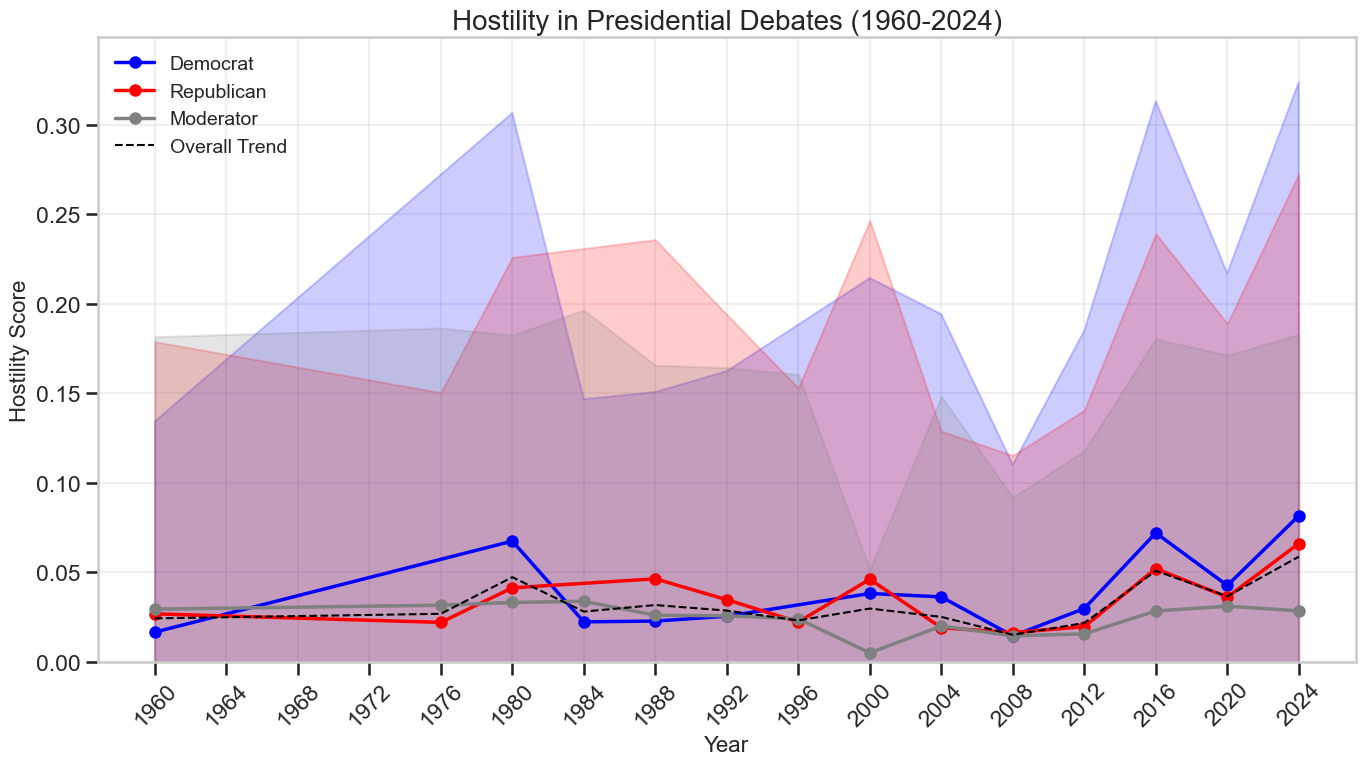


Analysis complete!


In [39]:
from debate_hostility_analysis import main

# Run the complete pipeline
main("debate_statements_with_party.csv")